In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows =10
pd.options.display.float_format = "{:.1f}".format

In [2]:
train_df = pd.read_csv("../input/google-machine-learning-crash-course/california_housing_train (5).xls")
test_df = pd.read_csv("../input/google-machine-learning-crash-course/california_housing_test (2).csv")
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [3]:
# Normalize dataset by converting each raw value to its Z-score
# For train dataset
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5242,0.7,-0.7,0.1,-0.0,0.5,1.3,0.7,-0.9,-0.6
16846,-1.9,2.9,-0.3,-0.3,-0.1,-0.4,-0.3,-0.8,-1.3
5932,0.7,-0.7,1.9,0.5,0.6,1.4,0.7,-0.6,-0.5
11196,-0.7,0.9,0.4,-0.9,-1.0,-0.9,-1.0,-0.4,-0.7
14302,-1.3,0.8,0.7,-0.4,-0.6,-0.6,-0.6,1.9,2.5


In [4]:
# Normalize test dataset
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [5]:
# Create Binary label
threshold = 265000.0   #75th percentile of median house value
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)
train_df_norm["median_house_value_is_high"].head(8000)

5242    0.0
16846   0.0
5932    0.0
11196   0.0
14302   1.0
         ..
9883    0.0
5708    0.0
1717    0.0
1290    1.0
11033   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [6]:
# Represent features in feature columns
# Create an empty list that will hold created feature columns 
feature_columns = []

# Create numerical feature column to represent median_income
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create numerical feature column to represent total_rooms
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the feature_columns list into a layer
feature_layer = layers.DenseFeatures(feature_columns)

# Print first 3 and last 3 rows of the feature_layer's output when applied to train_df_norm
feature_layer(dict(train_df_norm))

2022-02-15 18:50:15.151601: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.9149554 , -0.02094749],
       [-0.8311572 , -0.32233095],
       [-0.63043994,  0.47172502],
       ...,
       [-1.173844  , -0.49939948],
       [ 0.62773776,  0.703382  ],
       [-0.00968374,  0.8451286 ]], dtype=float32)>

In [7]:
# Define functions that build and train the model
def create_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model"""
    model = tf.keras.models.Sequential()
    
    # Add the feature layer to the model
    model.add(feature_layer)
    
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    activation=tf.sigmoid),)
    
    # Call the compile method to construct the layers into a model that tensorflow can execute
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=my_metrics)
    
    return model

def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    """Feed dataset into the model to train it"""
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs,shuffle=shuffle)
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs,hist


In [8]:
# Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs epoch"""
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
        
    plt.legend()

2022-02-15 18:50:15.453982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
170/170 [==============================] - 1s 2ms/step - loss: 0.6546 - accuracy: 0.7226 - precision: 0.4571 - recall: 0.5884
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5916 - accuracy: 0.7525 - precision: 0.5041 - recall: 0.5712
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5387 - accuracy: 0.7749 - precision: 0.5486 - recall: 0.5578
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4949 - accuracy: 0.7911 - precision: 0.5891 - recall: 0.5416
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.8070 - precision: 0.6384 - recall: 0.5246
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.8184 - precision: 0.6838 - recall: 0.5081
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4179 - accuracy: 0.8260 - precision: 0.7250 - recall: 0.4891
Epoch 8/20
170/170 [=====================

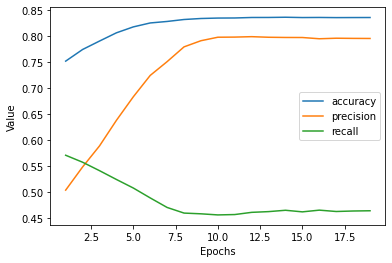

In [9]:
# Calling functions
# hyperparameters
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.53

# Establish the metrics the model will measure
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
           tf.keras.metrics.Recall(thresholds=classification_threshold, name='recall'),
          ]

my_model = create_model(learning_rate, feature_layer, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

list_of_metrics_to_plot = ['accuracy','precision','recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [10]:
# Evaluate the model
features = {name:np.array(value) for name,value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y =label, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.8317 - precision: 0.7757 - recall: 0.4544


[0.40687382221221924,
 0.8316666483879089,
 0.7757437229156494,
 0.45442360639572144]